In [283]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [284]:
import numpy as np
from sklearn.model_selection import train_test_split
input_size = 50
num_filters = 128
kernel_size = 5
output_size = 1
epochs = 100
learning_rate = 0.005
batch_size = 256


class ADFA_Dataset(Dataset):
    def __init__(self, files, label):
        self.samples = []
        self.labels = []
        self.max_len = 0
        for file in files:
            with open(file, 'r') as f:
                system_calls = [int(call) for call in f.read().split()]
                self.samples.append(system_calls)
                self.labels.append(label)


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = torch.tensor(self.samples[idx], dtype=torch.float)
        if len(sample) < input_size:
            sample = torch.cat((sample, torch.zeros(input_size - len(sample))))
        else:
            sample = sample[:input_size]
        return sample, torch.tensor(self.labels[idx], dtype=torch.float)


In [285]:
data_dir_train = "Training_Data_Master"
data_dir_attack = "Attack_Data_Master"
data_dir_valid = "Validation_Data_Master"

train_ben_file_path = []
for file in os.listdir(data_dir_train):
    train_ben_file_path.append(os.path.join(data_dir_train, file))

test_ben_file_path = []
for file in os.listdir(data_dir_valid):
    test_ben_file_path.append(os.path.join(data_dir_valid, file))

train_attack_path = []
test_attack_path = []
for attack_type in os.listdir(data_dir_attack):
    attack_type_path = os.path.join(data_dir_attack, attack_type)
    if os.path.isdir(attack_type_path):
        attack_files = [os.path.join(data_dir_attack, attack_type, i) for i in os.listdir(attack_type_path)]
        train, test = train_test_split(attack_files, test_size=0.2, random_state=42)
        train_attack_path.extend(train)
        test_attack_path.extend(test)
        

In [286]:
train_ben_data = ADFA_Dataset(train_ben_file_path, label=0)
train_attack_data = ADFA_Dataset(train_attack_path, label=1)
train_loader = DataLoader(train_ben_data + train_attack_data, batch_size=batch_size, shuffle=True)

test_ben_data = ADFA_Dataset(test_ben_file_path, label=0)
test_attack_data = ADFA_Dataset(test_attack_path, label=1)
test_loader = DataLoader(test_ben_data + test_attack_data, batch_size=batch_size, shuffle=True)

In [287]:
# Step 2: Define CNN Model
class CNNNetwork(nn.Module):
    def __init__(self, input_size, num_filters, kernel_size, output_size, dropout_prob):
        super(CNNNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size, stride=1, padding=kernel_size//2),
            nn.MaxPool1d(2),
            nn.BatchNorm1d([num_filters]),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=num_filters, out_channels=num_filters * 2, kernel_size=kernel_size, stride=1, padding=kernel_size//2),
            nn.MaxPool1d(2),
            nn.BatchNorm1d([num_filters * 2]),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=num_filters*2, out_channels=num_filters * 3, kernel_size=kernel_size, stride=1, padding=kernel_size//2),
            nn.MaxPool1d(2),
            nn.BatchNorm1d([num_filters * 3]),
            nn.LeakyReLU(),
            
        )
        self.model2 = nn.Sequential(
            nn.Linear(num_filters * 3 * (input_size // 8), 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            # nn.Dropout(dropout_prob),
            nn.Linear(128, output_size)
        )

        
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for CNN
        x = self.model(x)
        x = x.view(x.size(0), -1)  # Flatten
        out = self.model2(x)
        return out


Epoch [1/100], Loss: 0.6258
Epoch [2/100], Loss: 0.4965
Epoch [3/100], Loss: 0.4605
Epoch [4/100], Loss: 0.4026
Epoch [5/100], Loss: 0.3431
Epoch [6/100], Loss: 0.2849
Epoch [7/100], Loss: 0.2648
Epoch [8/100], Loss: 0.2305
Epoch [9/100], Loss: 0.1858
Epoch [10/100], Loss: 0.1318
Epoch [11/100], Loss: 0.0904
Epoch [12/100], Loss: 0.0757
Epoch [13/100], Loss: 0.0584
Epoch [14/100], Loss: 0.0582
Epoch [15/100], Loss: 0.0649
Epoch [16/100], Loss: 0.0481
Epoch [17/100], Loss: 0.0712
Epoch [18/100], Loss: 0.0599
Epoch [19/100], Loss: 0.0486
Epoch [20/100], Loss: 0.0475
Epoch [21/100], Loss: 0.0394
Epoch [22/100], Loss: 0.0391
Epoch [23/100], Loss: 0.0400
Epoch [24/100], Loss: 0.0392
Epoch [25/100], Loss: 0.0365
Epoch [26/100], Loss: 0.0398
Epoch [27/100], Loss: 0.0540
Epoch [28/100], Loss: 0.0523
Epoch [29/100], Loss: 0.0476
Epoch [30/100], Loss: 0.0369
Epoch [31/100], Loss: 0.0375
Epoch [32/100], Loss: 0.0354
Epoch [33/100], Loss: 0.0347
Epoch [34/100], Loss: 0.0370
Epoch [35/100], Loss: 0

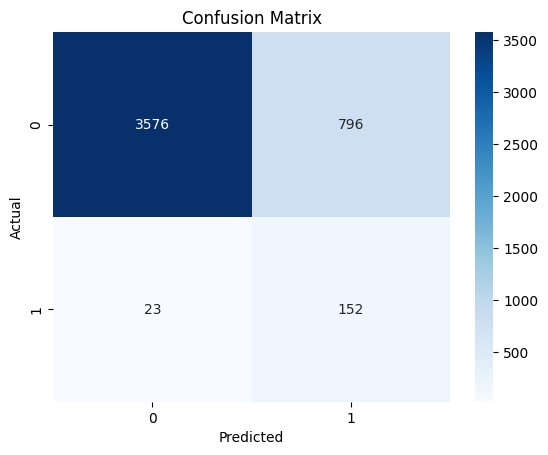

In [288]:
# Step 4: Define Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNNetwork(input_size, num_filters, kernel_size, output_size, 0).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Step 5: Training Loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Step 6: Validation Loop
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.round(torch.sigmoid(outputs.squeeze()))
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [289]:
acc = (conf_matrix[0][0] + conf_matrix[1][1])/conf_matrix.sum()
TPR = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[1][0])
FPR = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])

In [290]:
acc, TPR, FPR

(0.8198812403782714, 0.8685714285714285, 0.817932296431839)

In [291]:
len(train_attack_data)

571

In [292]:
len(test_attack_data)

175

In [293]:
len(train_ben_data)

833

In [294]:
len(test_ben_data)

4372